# INF8953DE: Assignment 3 - Policy Gradient Methods
    
Due on : Nov 19, 10:00 pm 


# Policy Gradient Methods

In this assignment, you will code RL agents that will learn a parameterized policy to solve the [CartPole](https://gym.openai.com/envs/CartPole-v1/) task. Simply put, the CartPole task is to balance a pole on a cart. Towards that, you will code and analyze different policy gradient methods that can maximize the objective of balancing the pole on cart without falling for maximum time. 

## Environment Details

For this assignment, we will use the [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/) environment provided in the [OpenAI-Gym](https://gym.openai.com/docs/). The following is a description of the task as given in the gym:

 **CartPole Task:** 
*A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.*
 
Detailed description and code can be found [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).




# Policy Gradient Skeleton Code

## Pseudocode
For this assignment you are asked to implement the policy gradient algorithms in the following pseudocode style. 

-------------------------------------------------------------------------------
**Input:** a differentiable policy network $\pi_\theta \in \mathcal{R}^d$ \\
**Algorithm parameters:** 


1.   $\alpha$: step size > 0
2.   n_iterations: number of gradient updates  > 0
3.   n_episodes: number of episodes per gradient update  > 0 

Initialize policy parameters 

loop for n_iterations: \\
  &emsp;&emsp;sample a dataset of episodes according to $\pi_\theta$ \\
  
  &emsp;&emsp;# compute policy gradient \\
  &emsp;&emsp;$\nabla_\theta J(\theta) = \sum_j \sum_t \psi_{jt} \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
  &emsp;&emsp; # where the first summation is over the episodes and the second summation is over the trajectory of the episode. \\
  
  &emsp;&emsp;# update policy parameters \\
  &emsp;&emsp;$\theta_i = \theta_i + \alpha \nabla_\theta J(\theta)$
  
------------------------------------------------------------------------------

Please note that this version of the algorithm is different from the one you will see in the textbook. Specifically, instead of computing the gradient for each episode, we collect a batch of episodes and then compute our gradient using this entire batch (or dataset).


## Installations and imports

In [1]:
# Run this cell

# install dependencies
!pip install torch torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (1,077 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package xvfb.
(Reading database ... 155222 files and director

In [2]:
# Run this cell

# type hinting 
from typing import Sequence, Tuple, Dict, Any, Optional

import numpy as np

# torch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

# env
import gym
from gym.wrappers import Monitor

# data manipulation, colab dispaly, and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

# misc util
import random, glob, base64, itertools
from pathlib import Path
from pprint import pprint

A util function to visualize the environment in colab:

In [3]:
# Run this cell
def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start(); 

## Building the Policy Network

The following piece of code is a util to make dense nets with PyTorch.

In [4]:
# Run this cell
class Model(nn.Module):
    def __init__(self, features: Sequence[int]):
        """Fully-connected Network

        Args:
            features: a list of ints like: [input_dim, 16, 16, output_dim]
        """
        super(Model, self).__init__()
        
        layers = []
        for i in range(len(features) - 1):
            layers.append(
                nn.Linear(
                    in_features=features[i],
                    out_features=features[i + 1],
                    )
            )
            if i != len(features) - 2:
                layers.append(nn.ReLU())
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, input):
        return self.net(input)

## Building the Base Agent Class

In [5]:
# Run this cell
class BaseAgent(object):
    """ The base agent class function.
    """
    
    def __init__(self, config: Dict[str, Any]):
        """
        args:
            config: configuration dictionary
        """
        self.config = config

        # assert len(config['policy_layers']) > 0 # this won't allow linear models

        # environment
        self.env = gym.make(config['env_id'])
        self.gamma = config['gamma']

        # set seed
        np.random.seed(seed=config['seed'])
        self.env.seed(config['seed'])
        torch.manual_seed(config['seed'])

        # build policy model
        _policy_logits_model = Model(
            [self.env.observation_space.shape[0]] + 
            config['policy_layers'] + # note that these are only the intermediate layers
            [self.env.action_space.n],
        )
        # NOTE: by design, policy model should take *batches* of states as input.
        # self.policy_model spits out the probability of each action
        self.policy_model = nn.Sequential(
            _policy_logits_model, nn.Softmax(dim=1), 
        )
        self.policy_optimizer = torch.optim.Adam(
            self.policy_model.parameters(), 
            lr=config['policy_learning_rate'],
        )
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)

        if config['use_baseline']:
            self.value_model = Model(
              [self.env.observation_space.shape[0]] + 
              self.config['value_layers'] + [1],
            )
            self.value_optimizer = torch.optim.Adam(self.value_model.parameters(), lr=config['value_learning_rate'])
    
    def _make_returns(self, rewards: np.ndarray):
        """ Compute the cumulative discounted rewards at each time step

        args:
            rewards: an array of step rewards

        returns:
            returns: an array of discounted returns from that timestep onward
        """
        returns = np.zeros_like(rewards)
        returns[-1] = rewards[-1]
        for t in reversed(range(len(rewards) - 1)):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        return returns
    
    # Method to implement
    def optimize_model(self, n_episodes: int) -> np.ndarray:
        """ Takes a gradient step on policy (and value) parameters using 
            `n_episodes` number of episodes. You'll need to implement
            this method for each part of this problem: namely, gather a 
            dataset of size `n_episodes`, approximate the gradient using 
            REINFORCE, and apply it to the model parameters. 

        args:
            n_episodes: number of trajectories in dataset

        returns:
            returns: the total discounted reward of each trajectory/episode.
        """
        
        raise NotImplementedError
    
    def train(self, n_episodes: int, n_iterations: int, plot: bool = True) -> Sequence[np.ndarray]:
        """ Train.
        args:
            n_episodes: number of episodes for each gradient step
            n_iterations: determine training duration
        """
        
        rewards = []
        for it in range(n_iterations):
            rewards.append(self.optimize_model(n_episodes))
            print(f'Iteration {it + 1}/{n_iterations}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')

        if plot:
            self.plot_rewards(rewards)

        return(rewards)
        
    @staticmethod
    def plot_rewards(rewards: Sequence[np.ndarray], ax: Optional[Any] = None):
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        if ax is None:
            sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        else:
            sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd', ax=ax);
        
    def evaluate(self):
        """ Evaluate and visualize a single episode.
        """
        
        observation = self.monitor_env.reset()
        observation = torch.tensor(observation, dtype=torch.float)[None, :]
        reward_episode = 0
        done = False
            
        while not done:
            probs = self.policy_model.forward(observation)
            action = torch.multinomial(probs, 1)[0] # draw samples from dist
            observation, reward, done, info = self.monitor_env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)[None, :]
            reward_episode += reward
        
        self.monitor_env.close()
        show_video("./gym-results")
        print(f'Reward: {reward_episode}')
        

#Qn 1. REINFORCE ALGORITHM [65 Marks]

## Qn 1.1 REINFORCE with episodal returns [25 Marks]


### Qn1.1.a: Implement a `REINFORCEv1` agent [20 Marks]

Implement a REINFORCE agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t G_0^j \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_0^j=\sum_{k = 0}^{\infty} \gamma^{k} R_{k+1}^j$ is the discounted return for the start state, $s_0^j$ for the episode $j$. . \\

Note that this is different from the REINFORCE algorithm we have seen in the class since we are using only the episodal return in the policy gradient computation for all state updates instead of using the corresponding return from individual states. We will implement the in-class version of REINFORCE in the next part.

You will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.


In [6]:
# Insert your code and run this cell
class REINFORCEv1Agent(BaseAgent):
    """ REINFORCE agent with total trajectory reward.
    """
    
    def optimize_model(self, n_episodes: int):

        """ YOU NEED TO IMPLEMENT THIS METHOD 

            This method is called at each training iteration and is responsible for 
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value

            HINTS:
                
                * Note that policy network model (self.policy_model) outputs the 
                probability of taking each discrete action. Hence, you need
                to sample from this distribution. Take a look at `self.evaluate()` 
                method in the `BaseAgent` class.

                * Keep in mind that policy network takes batches of states as 
                input, as opposed to a single state vector. This is by design,
                and good/common practice, however, you need to keep an eye on 
                the input/output dimensions.

        """

        # ======================================================================

            # INSERT YOUR CODE HERE !
        total_rewards = np.zeros((n_episodes,))
        loss = 0.0
        for i in range(n_episodes):

            current_state = self.env.reset()
            done = False
            episodes = []
            while not done:
                
                action_probability = self.policy_model.forward(torch.FloatTensor(current_state).unsqueeze(0))
                action = np.random.choice(np.array([0,1]), p = action_probability.data.numpy()[0])
                prev_state = current_state
              
                current_state, reward, done, extra = self.env.step(action)
                episodes.append((prev_state, action, reward))
                
                            
            reward_batch = np.array([r for (s,a,r) in episodes])

            expected_return = self._make_returns(reward_batch)
            total_rewards[i] = sum(reward_batch)

            expected_return_batch = torch.FloatTensor(expected_return)
            expected_returns = expected_return[0] * torch.ones_like(expected_return_batch)
            state_batch = torch.Tensor([s for (s,a,r) in episodes])
            action_batch = torch.Tensor([a for (s,a,r) in episodes])

            prediction_batch = self.policy_model.forward(state_batch)
            action_selected_batch = prediction_batch.gather(dim = 1, index = action_batch.long().view(-1,1)).squeeze()


            loss -= torch.sum(torch.log(action_selected_batch) * expected_return[0])

        # ======================================================================
        
        self.policy_optimizer.zero_grad()
        loss.backward()
        self.policy_optimizer.step()
        return total_rewards

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Iteration 1/100: rewards 18.32 +/- 9.27
Iteration 2/100: rewards 16.84 +/- 8.34
Iteration 3/100: rewards 17.9 +/- 8.31
Iteration 4/100: rewards 19.64 +/- 9.31
Iteration 5/100: rewards 20.52 +/- 10.7
Iteration 6/100: rewards 19.04 +/- 8.63
Iteration 7/100: rewards 22.04 +/- 12.4
Iteration 8/100: rewards 21.42 +/- 11.87
Iteration 9/100: rewards 19.28 +/- 7.65
Iteration 10/100: rewards 23.44 +/- 15.43
Iteration 11/100: rewards 20.8 +/- 8.2
Iteration 12/100: rewards 22.18 +/- 10.32
Iteration 13/100: rewards 25.76 +/- 12.51
Iteration 14/100: rewards 24.36 +/- 11.7
Iteration 15/100: rewards 25.8 +/- 15.26
Iteration 16/100: rewards 28.2 +/- 19.89
Iteration 17/100: rewards 23.44 +/- 9.81
Iteration 18/100: rewards 24.86 +/- 12.29
Iteration 19/100: rewards 29.04 +/- 15.09
Iteration 20/100: rewards 26.92 +/- 15.64
Iteration 21/100: rewards 25.76 +/- 13.08
Iteration 22/100: rewards 27.46 +/- 17.69
Iteration 23/100: rewards 33.04 +/- 18.04
Iteration 24/100: rewards 30.78 +/- 17.04
Iteration 25/100:

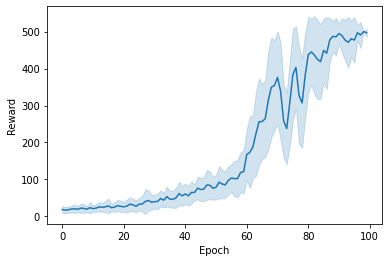

In [7]:
# You will be graded on this output this cell, so kindly run it

# This is an example configuration that is tuned for the above question. 
# keep the same config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': False,
}
agent = REINFORCEv1Agent(config)
REINFORCEv1_rewards = agent.train(n_episodes=50, n_iterations=100)

In [ ]:
# You will be graded on this output this cell, so kindly run it
agent.evaluate()

Reward: 500.0


### Qn:1.1.b:Why can we allow ourselves to use $\gamma = 1.0$ here? [3 Marks]


```
In REINFORCE, we assume a finite horizon, so the episodes end after some finite steps; because of that, we do not necessarily need a discount factor. 
Also, we have in Sutton Book: "If there is discounting
(gamma < 1) it should be treated as a form of termination.
Additionally, Reward discount reduces variance while reducing the impact of distant actions."

So here in this game, we have a termination so we can consider
that the future reward is as good as the immediate reward.
Furthermore, if we want to decrease variance in the Q-value
estimation, we can use discount factor < 1 ( like in
critic-actor algorithm)`
```

### Qn 1.1.c: If you have implemented everything correctly, you will notice that training iterations tend to take a bit longer towards the end compared to early stages of the training, why? [2 Marks]


```
Because at the early stage, the agent does not know how to play and it loose really fast, but when it trained properly,
which happens at the end, it can play longer ( it can play in more steps so it collects more data and it take longer to 
compute gradient and update the nueral networks)
and get more rewards, so it takes longer to train too.
```


## Qn 1.2 REINFORCE with returns [15 Marks]




###Qn 1.2.a Implement `REINFORCEv2` agent as described below. [10 Marks]

Implement a REINFORCE agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t G_t^j \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_t^j=\sum_{k=0}^{\infty} \gamma^{k} R_{t+k+1}^j$ is the discounted return computed starting from the current state, $s_t^j$ for the episode $j$. \\

Let's call this agent REINFORCEv2.

Note that you will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.

In [30]:
# Insert your code and run this cell
class REINFORCEv2Agent(BaseAgent):
    """ Not Vanilla REINFORCE Agent:
        *Not* vanilla, in the sense that we are now going to weight the action 
        logprobs, proportionate to the onward return as opposed to the total 
        episodic return. 
    """
    
    def optimize_model(self, n_episodes: int):
        """ YOU NEED TO IMPLEMENT THIS METHOD 

            This method is called at each training iteration and is responsible for 
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value

            HINTS:
                Hints from the previous section hold here except/plus that:
                
                * You probably DO need to call the `BaseAgent._make_returns`
                method in this part. 

                * You basically need to copy a lot of stuff you've done in the 
                previous part, but have to scale the logprobs with different 
                values.
        """
        # ======================================================================

          # YOUR CODE HERE !
        total_rewards = np.zeros((n_episodes))
        loss = 0.0
        for i in range(n_episodes):

            current_state = self.env.reset()
            done = False
            episodes = []
            while not done:
                
                action_probability = self.policy_model.forward(torch.FloatTensor(current_state).unsqueeze(0))
                action = np.random.choice(np.array([0,1]), p = action_probability.data.numpy()[0])
                prev_state = current_state
                current_state, reward, done, extra = self.env.step(action)
                episodes.append((prev_state, action, reward))
            
            reward_batch = np.array([r for (s,a,r) in episodes])

            expected_return = self._make_returns( reward_batch)
            total_rewards[i] = sum(reward_batch)
            
            expected_returns_batch=torch.FloatTensor(expected_return)


            #expected_return_batch = torch.FloatTensor(expected_return)
            state_batch = torch.Tensor([s for (s,a,r) in episodes])
            action_batch = torch.Tensor([a for (s,a,r) in episodes])

            prediction_batch = self.policy_model.forward(state_batch)
            action_selected_batch = prediction_batch.gather(dim = 1, index = action_batch.long().view(-1,1)).squeeze()


            loss += - torch.sum(torch.log(action_selected_batch) * expected_returns_batch)
            


        # ======================================================================
        
        self.policy_optimizer.zero_grad()
        loss.backward()
        self.policy_optimizer.step()
        return total_rewards

Iteration 1/100: rewards 17.8 +/- 6.91
Iteration 2/100: rewards 20.32 +/- 10.14
Iteration 3/100: rewards 17.28 +/- 6.96
Iteration 4/100: rewards 21.2 +/- 9.9
Iteration 5/100: rewards 21.34 +/- 10.76
Iteration 6/100: rewards 23.64 +/- 12.72
Iteration 7/100: rewards 27.66 +/- 14.92
Iteration 8/100: rewards 28.7 +/- 13.69
Iteration 9/100: rewards 24.06 +/- 11.39
Iteration 10/100: rewards 29.26 +/- 14.91
Iteration 11/100: rewards 30.6 +/- 16.09
Iteration 12/100: rewards 29.58 +/- 16.35
Iteration 13/100: rewards 33.3 +/- 17.14
Iteration 14/100: rewards 30.04 +/- 17.77
Iteration 15/100: rewards 34.86 +/- 21.06
Iteration 16/100: rewards 38.68 +/- 24.51
Iteration 17/100: rewards 38.64 +/- 22.31
Iteration 18/100: rewards 44.34 +/- 24.67
Iteration 19/100: rewards 39.5 +/- 15.92
Iteration 20/100: rewards 41.2 +/- 24.2
Iteration 21/100: rewards 42.06 +/- 20.15
Iteration 22/100: rewards 48.96 +/- 27.33
Iteration 23/100: rewards 47.06 +/- 21.36
Iteration 24/100: rewards 54.82 +/- 30.83
Iteration 25/

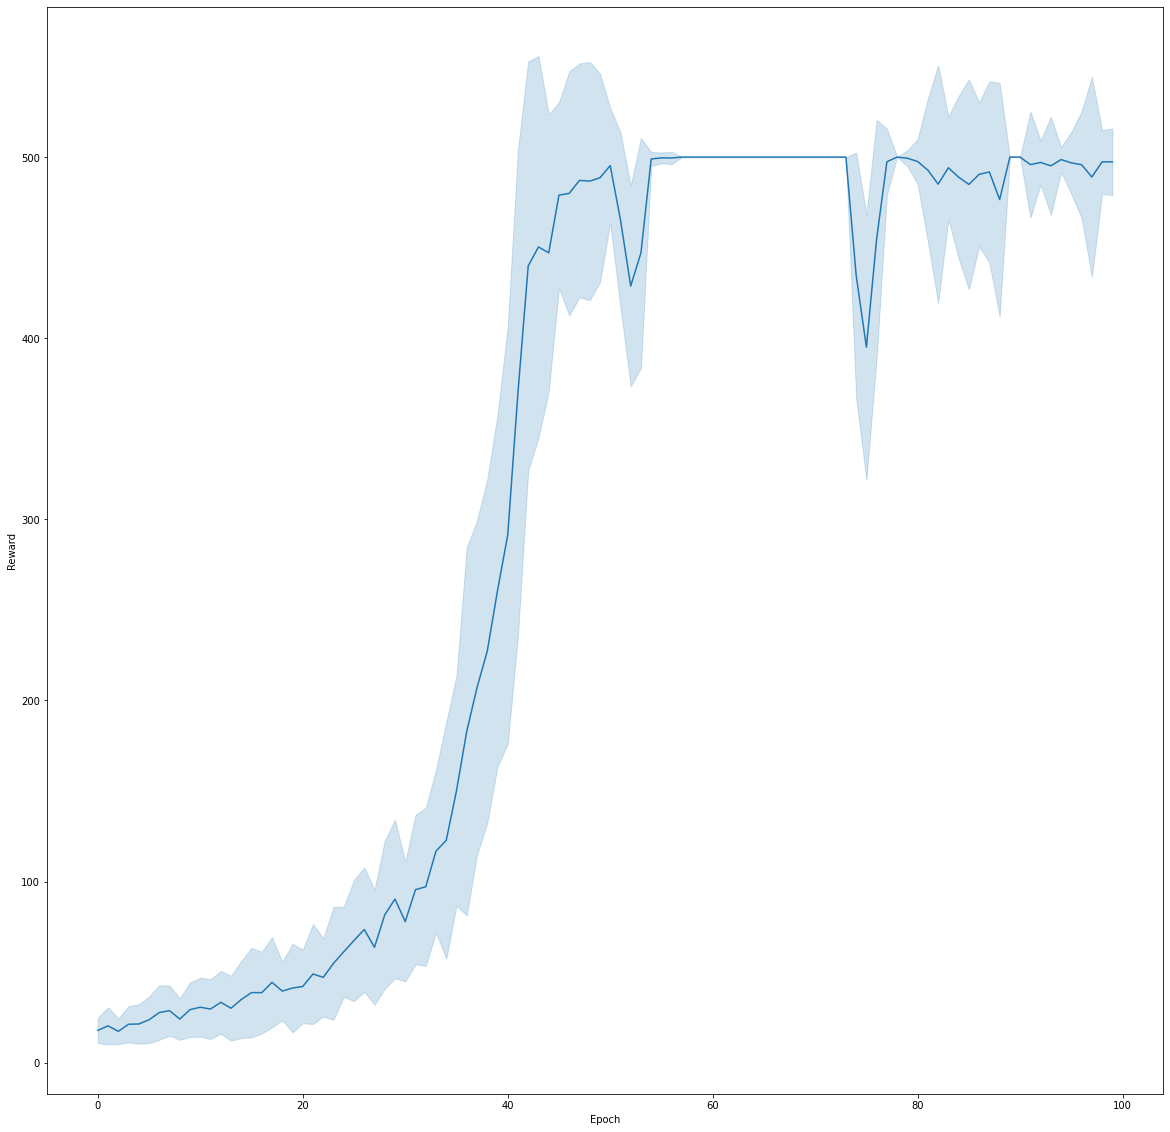

In [31]:
# You will be graded on this output this cell, so kindly run it
# keep the same config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': False,
}
agent = REINFORCEv2Agent(config)
REINFORCEv2_rewards = agent.train(n_episodes=50, n_iterations=100)

In [ ]:
# You will be graded on this output this cell, so kindly run it
agent.evaluate()

Reward: 500.0


### Qn 1.2.b: Plot and compare the performance of the `REINFORCEv1` and `REINFORCEv2` agents for $\gamma=1$. Report your observations and provide explanations for the same. [5 Marks]


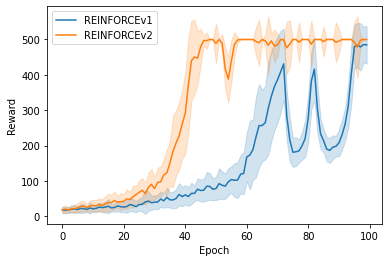

In [ ]:
# You will be graded on this output this cell, so kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv1_rewards, ax)
BaseAgent.plot_rewards(REINFORCEv2_rewards, ax)
plt.rcParams['figure.figsize'] = [20, 20]
plt.legend(labels=['REINFORCEv1', 'REINFORCEv2'])

```
REINFORCE is a monte carlo algorithm which is good for episodic case so it may have high variance and produce slow learning.
REINFORCEv2 is converged faster and also is more stable and smoother, and less noisy than REINFORCEv1. The difference between these two plots are the discounted return we used.
In REINFORCEv1, we used expected returns that start from the first state for all steps in episodes; on the other hand, in REINFORCEv2, we used the expected return, which computed starting from the current state on the episodes. So in REINFORCEv1, instead of using discounted return for each step, we used the expected return of the first step for all the steps on episodes, and it is clear that why it is noisier that second algorithm```

##Qn 1.3 REINFORCE WITH baseline 25 Marks]

### Qn 1.3.a Implement 'REINFORCEv2+B' agent as described below [15 Marks]

Implement a REINFORCE agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t (G_t^j - B(s_t^j)) \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_t^j=\sum_{k=0}^{\infty} \gamma^{k} r_{t+k+1}^j$ is the discounted return computed starting from the current state, $s_t^j$ for the episode $j$. \\

Herein implement the baseline to be an estimator of the state-value function of the state at $t$, $B(s_t)=V(s_t)$. Towards that implement a value network with parameters, $w$ to estimate the value of a state,i.e $B(s_t, w) = V(s_t)$. 

Let's call this agent REINFORCEv2+B.

Note that you will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.

In [8]:
# Insert your code and run this cell
class REINFORCEv2PlusBaselineAgent(BaseAgent):
    """ Baseline Agent: 
        Here we try to reduce the variance by introducing a baseline, which is 
        the value function in this case.
    """
    
    def optimize_model(self, n_episodes: int):
        """ YOU NEED TO IMPLEMENT THIS METHOD 

            This method is called at each training iteration and is responsible for 
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value

            In addition here, you will have to compute the loss of the value function and 
            call auto-diff on this loss to updae the parameters of the value network.

            Here you have access to and need to make use of `self.value_model`
            and `self.value_optimizer`, and have to form a loss for updating the
            value function. 

            HINT:
                * You need to use torch's `.detach()` to prevent re-flowing 
                the gradients.
        """
        # ======================================================================

          # YOUR CODE HERE !
        total_rewards = np.zeros((n_episodes))
        policy_loss = 0.0
        value_loss = 0.0
        for i in range(n_episodes):

            current_state = self.env.reset()
            done = False
            episodes = []
            while not done:
                #action_probability = self.policy_model(torch.from_numpy(current_state))
                #print(current_state)
                #print(torch.from_numpy(current_state).float())

                action_probability = self.policy_model.forward(torch.FloatTensor(current_state).unsqueeze(0))

                action = np.random.choice(np.array([0,1]), p = action_probability.data.numpy()[0])
                prev_state = current_state
                current_state, reward, done, extra = self.env.step(action)
                episodes.append((prev_state, action, reward))
                #state = next_state
            
            reward_batch = np.array([r for (s,a,r) in episodes])



            expected_return = self._make_returns( reward_batch)
            total_rewards[i] = sum(reward_batch)
            
            expected_returns_batch=torch.FloatTensor(expected_return)


            #expected_return_batch = torch.FloatTensor(expected_return)
            state_batch = torch.Tensor([s for (s,a,r) in episodes])
            action_batch = torch.Tensor([a for (s,a,r) in episodes])

            value_baseline = self.value_model.forward(state_batch)


            prediction_batch = self.policy_model.forward(state_batch)
            action_selected_batch = prediction_batch.gather(dim = 1, index = action_batch.long().view(-1,1)).squeeze()


            policy_loss -= torch.sum(torch.log(action_selected_batch) * (expected_returns_batch - value_baseline.detach()))
            value_loss += torch.sum(expected_returns_batch - value_baseline).pow(2)
        value_loss = value_loss / n_episodes


        

        # ======================================================================
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # additionally we update the value network parameters
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        return total_rewards
   

Iteration 1/100: rewards 17.8 +/- 6.91
Iteration 2/100: rewards 20.32 +/- 10.14
Iteration 3/100: rewards 17.28 +/- 6.96
Iteration 4/100: rewards 21.2 +/- 9.9
Iteration 5/100: rewards 21.74 +/- 9.89
Iteration 6/100: rewards 25.78 +/- 15.53
Iteration 7/100: rewards 27.28 +/- 15.11
Iteration 8/100: rewards 28.48 +/- 13.84
Iteration 9/100: rewards 30.32 +/- 22.14
Iteration 10/100: rewards 25.3 +/- 10.51
Iteration 11/100: rewards 30.52 +/- 17.68
Iteration 12/100: rewards 33.14 +/- 18.68
Iteration 13/100: rewards 31.72 +/- 15.71
Iteration 14/100: rewards 33.52 +/- 18.08
Iteration 15/100: rewards 28.18 +/- 13.35
Iteration 16/100: rewards 37.36 +/- 20.03
Iteration 17/100: rewards 33.42 +/- 16.93
Iteration 18/100: rewards 41.9 +/- 22.16
Iteration 19/100: rewards 45.74 +/- 22.13
Iteration 20/100: rewards 41.48 +/- 25.45
Iteration 21/100: rewards 41.58 +/- 22.96
Iteration 22/100: rewards 48.42 +/- 22.76
Iteration 23/100: rewards 57.88 +/- 20.29
Iteration 24/100: rewards 52.94 +/- 19.06
Iteration 

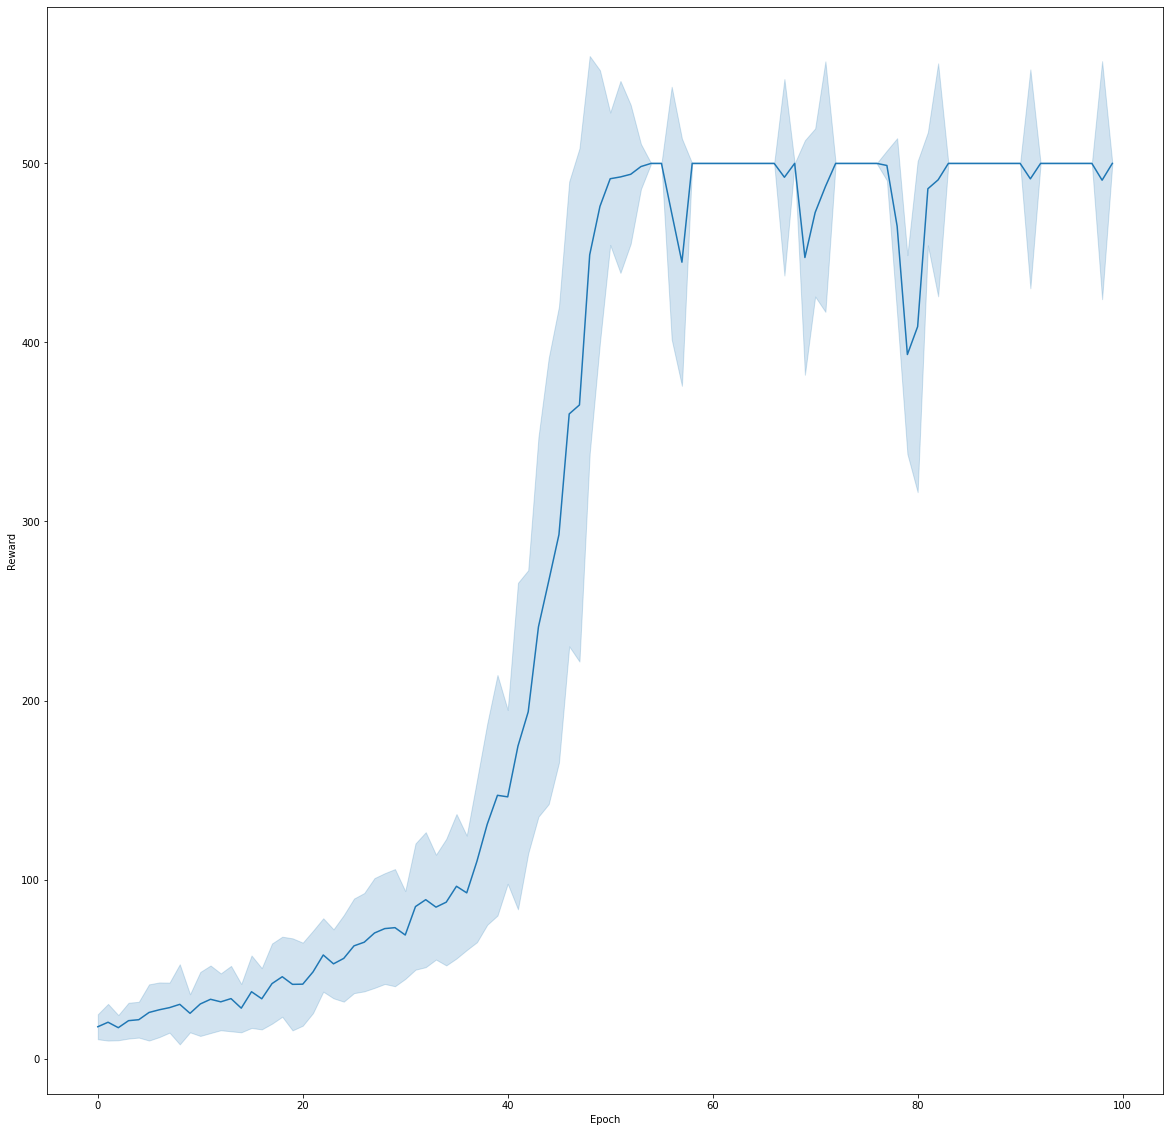

In [23]:
# You will be graded on this output this cell, so kindly run it.
# keep the config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8, 8],
    'value_learning_rate': 5e-3,
}
agent = REINFORCEv2PlusBaselineAgent(config)
REINFORCEv2PlusBaselineAgent_rewards = agent.train(n_episodes=50, n_iterations=100)

In [9]:
# You will be graded on this output this cell, so kindly run this cell.
agent.evaluate()

Reward: 500.0


### Qn 1.3.b : Does introducing baselines have a meaning beyond variance reduction? [5 Marks ]




```
yes, it can affect the optimization process(learning rate)
when we want to estimate the gradient, the high variance is one of the major problems, leading to slow convergence and noisy results. 
Using the baseline, we expect it to reduce the variance, and the expected return would remain unbiased.
Moreover, it can increase the stability and speed of policy learning with REINFORCE

```


### Qn 1.3.c Plot and compare `REINFORCEv2+B` for  $\gamma \in \{0.95, 0.975, 0.99, 0.995, 1\}$. [ 5 Marks]
Report your observations and explain the same.

Iteration 1/100: rewards 17.8 +/- 6.91
Iteration 2/100: rewards 20.32 +/- 10.14
Iteration 3/100: rewards 17.28 +/- 6.96
Iteration 4/100: rewards 21.2 +/- 9.9
Iteration 5/100: rewards 20.94 +/- 10.87
Iteration 6/100: rewards 24.04 +/- 11.44
Iteration 7/100: rewards 27.66 +/- 14.77
Iteration 8/100: rewards 27.14 +/- 13.01
Iteration 9/100: rewards 26.5 +/- 12.02
Iteration 10/100: rewards 26.76 +/- 15.85
Iteration 11/100: rewards 32.1 +/- 20.61
Iteration 12/100: rewards 30.46 +/- 14.4
Iteration 13/100: rewards 28.28 +/- 12.56
Iteration 14/100: rewards 32.64 +/- 19.51
Iteration 15/100: rewards 34.26 +/- 22.86
Iteration 16/100: rewards 35.18 +/- 17.08
Iteration 17/100: rewards 34.24 +/- 17.11
Iteration 18/100: rewards 39.84 +/- 16.24
Iteration 19/100: rewards 41.22 +/- 23.37
Iteration 20/100: rewards 41.18 +/- 23.31
Iteration 21/100: rewards 48.6 +/- 24.18
Iteration 22/100: rewards 48.74 +/- 26.88
Iteration 23/100: rewards 51.34 +/- 22.4
Iteration 24/100: rewards 63.58 +/- 24.23
Iteration 25

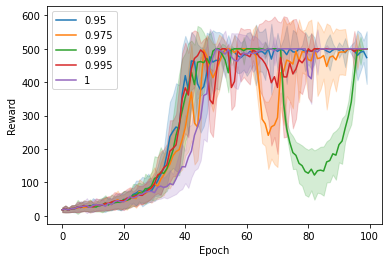

In [18]:
# Insert your code here and run this cell
# You will be graded on this output this cell, so kindly run it.
# keep the config 
gammas = [0.95, 0.975, 0.99, 0.995, 1]
for i,gamma in enumerate(gammas):
    config = {
        'env_id': 'CartPole-v1',
        'seed': 8953,
        'gamma': gammas[i],
        'policy_layers': [16, 8],
        'policy_learning_rate': 1e-2,
        'use_baseline': True,
        'value_layers': [16, 8, 8],
        'value_learning_rate': 5e-3,
    }
    agent = REINFORCEv2PlusBaselineAgent(config)
    REINFORCEv2PlusBaselineAgent_rewards = agent.train(n_episodes=50, n_iterations=100)
plt.legend(labels=[0.95, 0.975, 0.99, 0.995, 1])





```
The baseline function is a function which try to not change the expected value (so it would be unbiased), but it will decrease the variance.
Gamma = 1 starts to converge later than the other gammas, but it also converges really fast(around episode 60).
It's more stable and less noisy.(low biased) Also, it has high variance either.

Gamma = 0.995 starts to converge faster but is unstable(biased) and converges later than gamma = 1( around episode 80).
Compared to the other plot, it has less variance compare to Gamma =1.

gamma = 0.99. It's the most unstable( noisy-biased) plot and also converges really slow (around episode 100)

gamma = 0.975 it's converge really slow too(arount episode 100) and it is noisy(unstable) plot(biased).

Gamma = 0.95; it is starting to converge really soon, and compared to the last plot,
it converges really fast (around episode 50). 

by increasing the gamma, the variance is increasing as well and we will have unbiased expected return


```

#Qn 2. ACTOR CRITIC [35 Marks]


### Qn 2.1 Implement a one-step Actor-Critic agent below [15 Marks]. 

Implement an actor critic agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t (G_{t:t+1}^j - V(s_t^j)) \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_{t:t+1}^j= R_t + \gamma V(s_{t+1}^j)$ is the truncated one-step return computed starting from the current state, $s_t^j$ for the episode $j$. \\


Implement the critic network to be an estimator for state-value function.

Note that you will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.

In [12]:
# Insert your code and run this cell
class ActorCriticAgent(BaseAgent):
    """ A2C Agent: Actor-Critic
        Here we try to FURTHER reduce the variance via bootstrapping.
    """
    
    def optimize_model(self, n_episodes: int):
        """ YOU NEED TO IMPLEMENT THIS METHOD 

            This method is called at each training iteration and is responsible for 
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value
            In addition implement the critic network
            HINT:
                * If you've made it this far you don't need another hint!
        """
        # ======================================================================

          # YOUR CODE HERE !
        total_rewards = np.zeros((n_episodes))
        policy_loss = 0.0
        value_loss = 0.0
        for i in range(n_episodes):

            current_state = self.env.reset()
            done = False
            episodes = []
            while not done:
                
                action_probability = self.policy_model.forward(torch.FloatTensor(current_state).unsqueeze(0))

                action = np.random.choice(np.array([0,1]), p = action_probability.data.numpy()[0])
                prev_state = current_state
                current_state, reward, done, extra = self.env.step(action)
                episodes.append((prev_state, action, reward))
            
            reward_batch = np.array([r for (s,a,r) in episodes])



            expected_return = self._make_returns(reward_batch)
            total_rewards[i] = sum(reward_batch)
            
            expected_returns_batch = torch.FloatTensor(expected_return)


            state_batch = torch.Tensor([s for (s,a,r) in episodes])
            action_batch = torch.Tensor([a for (s,a,r) in episodes])

            value = self.value_model.forward(state_batch)

            G = torch.zeros_like(value)
            G[-1] = reward_batch[-1]
            for t in reversed(range(len(reward_batch) -1)):
                G[t] = (reward_batch[t] + self.gamma * value[t+1]).detach()
            
            
            

            prediction_batch = self.policy_model.forward(state_batch)
            action_selected_batch = prediction_batch.gather(dim = 1, index = action_batch.long().view(-1,1)).squeeze()

            policy_loss += - torch.sum(torch.log(action_selected_batch) * (G - value.detach()))
            value_loss +=   torch.sum((G.detach() - value).pow(2))

        value_loss /= n_episodes


        


        # ======================================================================
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        return total_rewards
   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Iteration 1/500: rewards 17.91 +/- 6.97
Iteration 2/500: rewards 17.25 +/- 5.96
Iteration 3/500: rewards 18.84 +/- 8.69
Iteration 4/500: rewards 20.47 +/- 13.35
Iteration 5/500: rewards 20.97 +/- 10.87
Iteration 6/500: rewards 19.44 +/- 8.52
Iteration 7/500: rewards 19.03 +/- 8.87
Iteration 8/500: rewards 18.91 +/- 9.76
Iteration 9/500: rewards 20.91 +/- 11.14
Iteration 10/500: rewards 17.16 +/- 6.27
Iteration 11/500: rewards 21.34 +/- 12.76
Iteration 12/500: rewards 22.22 +/- 12.34
Iteration 13/500: rewards 19.28 +/- 6.35
Iteration 14/500: rewards 22.16 +/- 9.25
Iteration 15/500: rewards 21.19 +/- 14.63
Iteration 16/500: rewards 20.0 +/- 8.7
Iteration 17/500: rewards 21.78 +/- 9.8
Iteration 18/500: rewards 22.69 +/- 13.07
Iteration 19/500: rewards 21.59 +/- 13.93
Iteration 20/500: rewards 22.19 +/- 11.55
Iteration 21/500: rewards 23.84 +/- 13.68
Iteration 22/500: rewards 18.91 +/- 6.68
Iteration 23/500: rewards 23.62 +/- 15.24
Iteration 24/500: rewards 18.97 +/- 10.01
Iteration 25/500

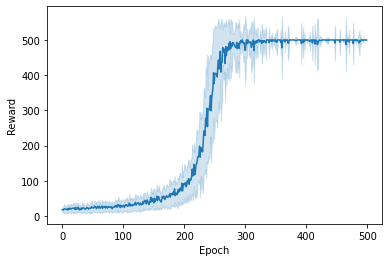

In [13]:
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-3,
    'use_baseline': True,
    'value_layers': [16, 8],
    'value_learning_rate': 1e-2,
}
agent = ActorCriticAgent(config)
ActorCritic_sum_rewards = agent.train(n_episodes=32, n_iterations=500)


In [14]:
# You will be graded on this output of this cell; so kindly run it 
agent.evaluate()

Reward: 500.0


### Qn 2.2: Eventhough the previous `REINFORCEv2+B` agent used a value estimator network similar to that of the Actor-Critic agent why is not called an Actor-Critic method ? [ 3 Marks]

```
In the REINFORCE algorithm with state value function as a baseline,
we use discounted return(expected return) generated from
the current trajectory as our target(like monte Carlo). 
So it is an offline unbiased algorithm, but in the ACTOR-CRITIC algorithm,
 we use the bootstrapping estimate as our target(like TD learning),
which updates every step using predictions of future return A critic is just an observer that provides feedback to an actor. 
And also, it has an impact on a biased-variance trade-off.
Actor-critic helps decrease the variance, which also improves the performance. 
To conclude, we can see REINFORCE with baseline as a version
 of actor-critic algorithm where the critic is the monte Carlo estimator

```

### Qn 2.3: How does the Actor-Critic algorithm reduces variance? What about bias? We are using one-step rewards here, is there a way we can strike a balance between variance and bias? [5 Marks]

```
In the actor-critic algorithm, we have an actor which
defines the policy and a critic which provides a more
reduced variance reward signal to update the actor.
Variance can be subtracted from a Monte-Carlo sample using
a more stable learned value function V(s) in the critic. 
This value function is typically a neural network and can
be learned using either Monte-Carlo sampling or Temporal
difference (TD) learning.
So this value function can be biased if we use temporal
difference. So as we know, variance and biased are
inversely related, so by having a lower variance, we have a
higher bias.

Also, how does it balance between variance and bias?
Increasing the reward step gets more similar to
monte-Carlo, so we would estimate the G_t with higher
accuracy, so it decreases the bias but increases the
variance on the other hand. So by deciding how many steps
we have in our critic, we can handle the variance-bias trade-off.

Also, Discount Factor Ensure that this captures how far
ahead agents should be predicting rewards for environments
where agents need to think thousands of steps into the
future, between pure TD learning and pure Monte-Carlo
sampling using a lambda parameter. By setting lambda to 0,
the algorithm reduces to TD learning, while setting it to 1
produces Monte-Carlo sampling.
```

### Qn 2.4: Challenge! Can you tweak the hyperparameters of Actor-Critic to achieve better performance? Compare your results againts what you already have in section 3.1, in a single plot. [ 5 Marks]

Tune $\gamma$ within the same range as in Qn. 1.3.c and tune the hypereparameters of the value networks.

Iteration 1/100: rewards 17.8 +/- 6.91
Iteration 2/100: rewards 19.86 +/- 9.96
Iteration 3/100: rewards 17.78 +/- 7.26
Iteration 4/100: rewards 19.92 +/- 14.35
Iteration 5/100: rewards 20.82 +/- 9.36
Iteration 6/100: rewards 22.1 +/- 12.22
Iteration 7/100: rewards 25.1 +/- 15.89
Iteration 8/100: rewards 22.36 +/- 10.46
Iteration 9/100: rewards 26.64 +/- 15.97
Iteration 10/100: rewards 24.9 +/- 10.85
Iteration 11/100: rewards 27.4 +/- 15.11
Iteration 12/100: rewards 25.36 +/- 14.72
Iteration 13/100: rewards 23.0 +/- 12.22
Iteration 14/100: rewards 28.2 +/- 13.55
Iteration 15/100: rewards 27.3 +/- 15.19
Iteration 16/100: rewards 28.12 +/- 16.14
Iteration 17/100: rewards 30.34 +/- 15.64
Iteration 18/100: rewards 27.88 +/- 14.27
Iteration 19/100: rewards 29.76 +/- 14.35
Iteration 20/100: rewards 31.36 +/- 16.38
Iteration 21/100: rewards 39.6 +/- 19.74
Iteration 22/100: rewards 30.32 +/- 13.43
Iteration 23/100: rewards 33.56 +/- 15.85
Iteration 24/100: rewards 39.12 +/- 23.75
Iteration 25/1

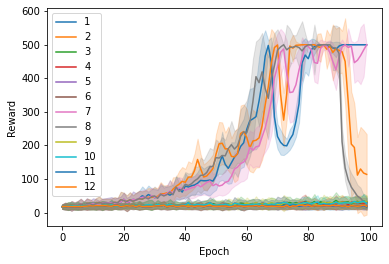

In [18]:
# Insert your code here to search for best hyper-parameters
Gamma = [1, 0.99]
Policy_network = [1e-2, 1e-3, 1e-4]
Value_network = [1e-2, 1e-3]
N_episodes = 50
N_iterations = 750
for i in range(len(Gamma)):
    for j in range(len(Policy_network)):
        for k in range(len(Value_network)):
            config = {
                'env_id': 'CartPole-v1',
                'seed': 8953,
                'gamma': Gamma[i],
                'policy_layers': [16, 8],
                'policy_learning_rate': Policy_network[j],
                'use_baseline': True,
                'value_layers': [16, 8, 8],
                'value_learning_rate': Value_network[k],
                    }
            agent = ActorCriticAgent(config)
            ActorCritic_rewards = agent.train(n_episodes=50, n_iterations=100)

plt.legend(labels=[1,2,3,4,5,6,7,8,9,10,11,12])

#(1, 1e-2, 1e-2) --- (1, 1e-2, 1e-3) --- (1, 1e-3, 1e-2) --- (1, 1e-3, 1e-3)
#(1, 1e-4, 1e-2) --- (1, 1e-4, 1e-3) --- (0.99, 1e-2, 1e-2) --- (0.99, 1e-2, 1e-3)
#(0.99, 1e-3, 1e-2) --- (0.99, 1e-3, 1e-3) --- (0.99, 1e-4, 1e-2) --- (0.99, 1e-4, 1e-3)



Iteration 1/100: rewards 18.18 +/- 8.2
Iteration 2/100: rewards 18.72 +/- 8.63
Iteration 3/100: rewards 19.2 +/- 7.08
Iteration 4/100: rewards 20.69 +/- 11.44
Iteration 5/100: rewards 23.89 +/- 13.58
Iteration 6/100: rewards 23.49 +/- 11.38
Iteration 7/100: rewards 24.57 +/- 14.02
Iteration 8/100: rewards 23.24 +/- 11.42
Iteration 9/100: rewards 27.12 +/- 14.87
Iteration 10/100: rewards 25.83 +/- 12.97
Iteration 11/100: rewards 24.99 +/- 14.18
Iteration 12/100: rewards 25.23 +/- 15.5
Iteration 13/100: rewards 25.46 +/- 12.85
Iteration 14/100: rewards 26.8 +/- 15.6
Iteration 15/100: rewards 24.59 +/- 13.29
Iteration 16/100: rewards 30.38 +/- 17.43
Iteration 17/100: rewards 33.69 +/- 18.84
Iteration 18/100: rewards 29.6 +/- 16.01
Iteration 19/100: rewards 32.11 +/- 18.3
Iteration 20/100: rewards 33.77 +/- 22.84
Iteration 21/100: rewards 40.99 +/- 20.91
Iteration 22/100: rewards 40.6 +/- 21.71
Iteration 23/100: rewards 34.85 +/- 18.65
Iteration 24/100: rewards 46.38 +/- 27.18
Iteration 25

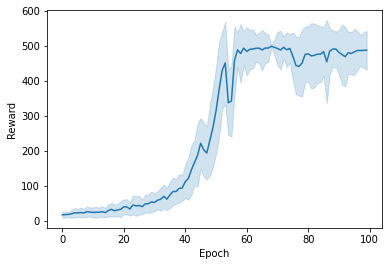

In [19]:
#0.99, 1e-2, 1e-2
# Provide your best config here and run this cell
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 0.99,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8, 8],
    'value_learning_rate': 1e-2,
}
agent = ActorCriticAgent(config)
ActorCritic_rewards2 = agent.train(n_episodes=100, n_iterations=100)

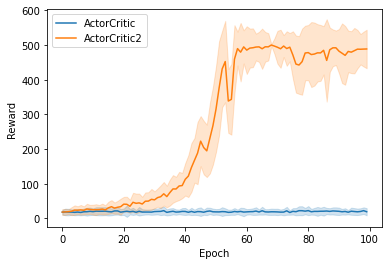

In [20]:
# You will be graded on the output of this cell; So kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(ActorCritic_rewards, ax)
BaseAgent.plot_rewards(ActorCritic_rewards2, ax)
plt.rcParams['figure.figsize'] = [20, 20]
plt.legend(labels=['ActorCritic', 'ActorCritic2'])

### Qn 2.5: Compare and plot `REINFORCEv2+B' method and 'ACTOR-CRITIC' method. [5 Marks]
Report your observations and provide explanations for the same. 

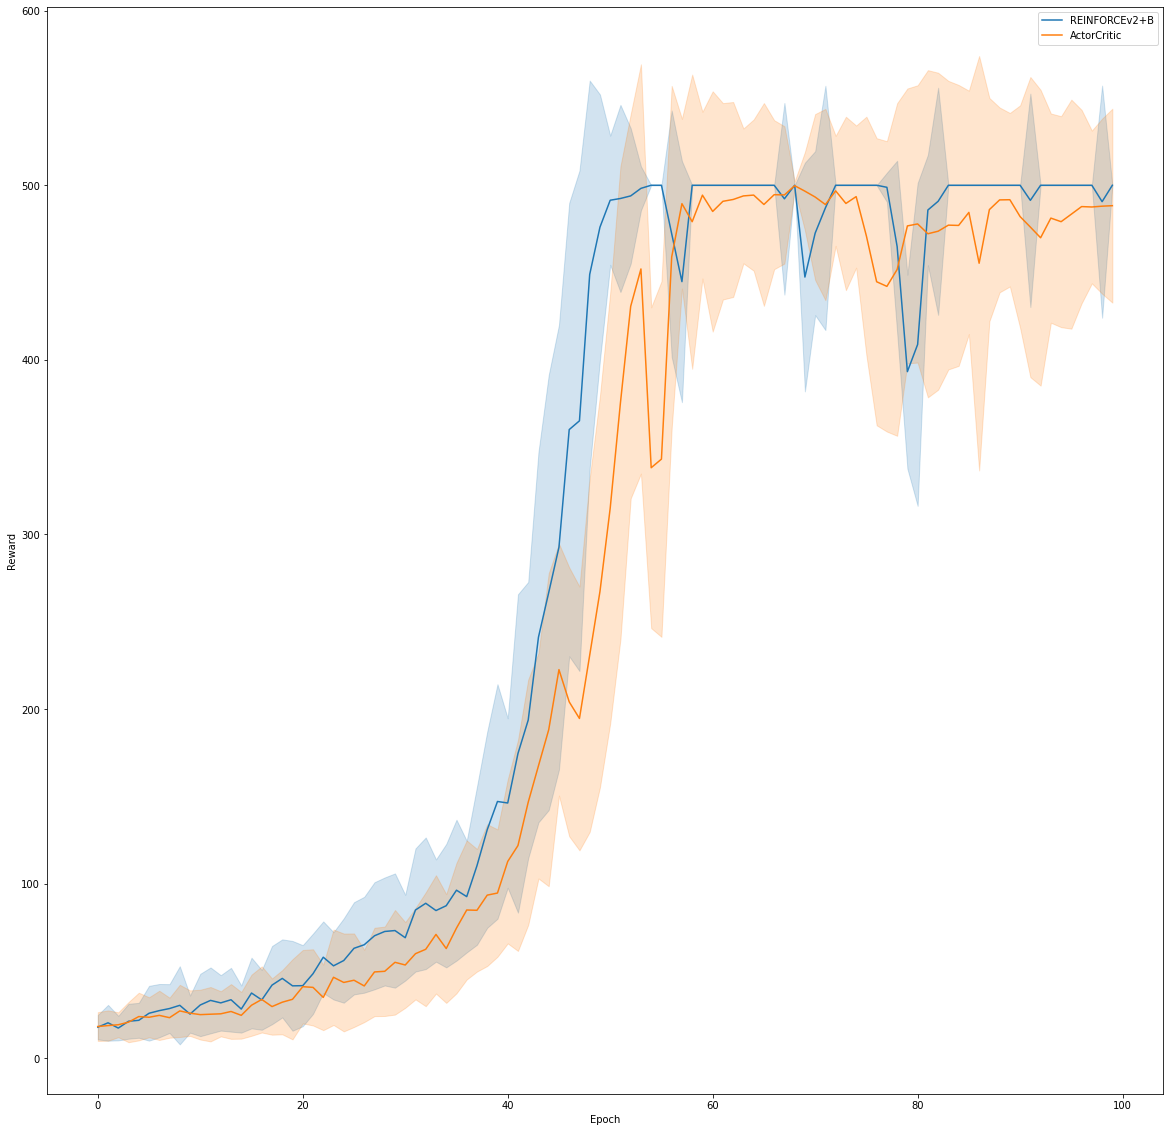

In [27]:
# You will be graded on the output of this cell; So kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards, ax)
BaseAgent.plot_rewards(ActorCritic_rewards2, ax)
plt.rcParams['figure.figsize'] = [20, 20]
plt.legend(labels=['REINFORCEv2+B', 'ActorCritic'])



```
The actor-critic method should have a lower variance
and high biased compared to REINFORCE with baseline
so it is noisier. but here at the later episodes
the actor-critic has more variance, I think, cause of
the config the actor-critic did not train very 
well in 100 episodes. also because of this problem
 the REINFORCE has better learning cure and it converged faster.

```



### Qn 2.6: Plot all methods [2 Marks]

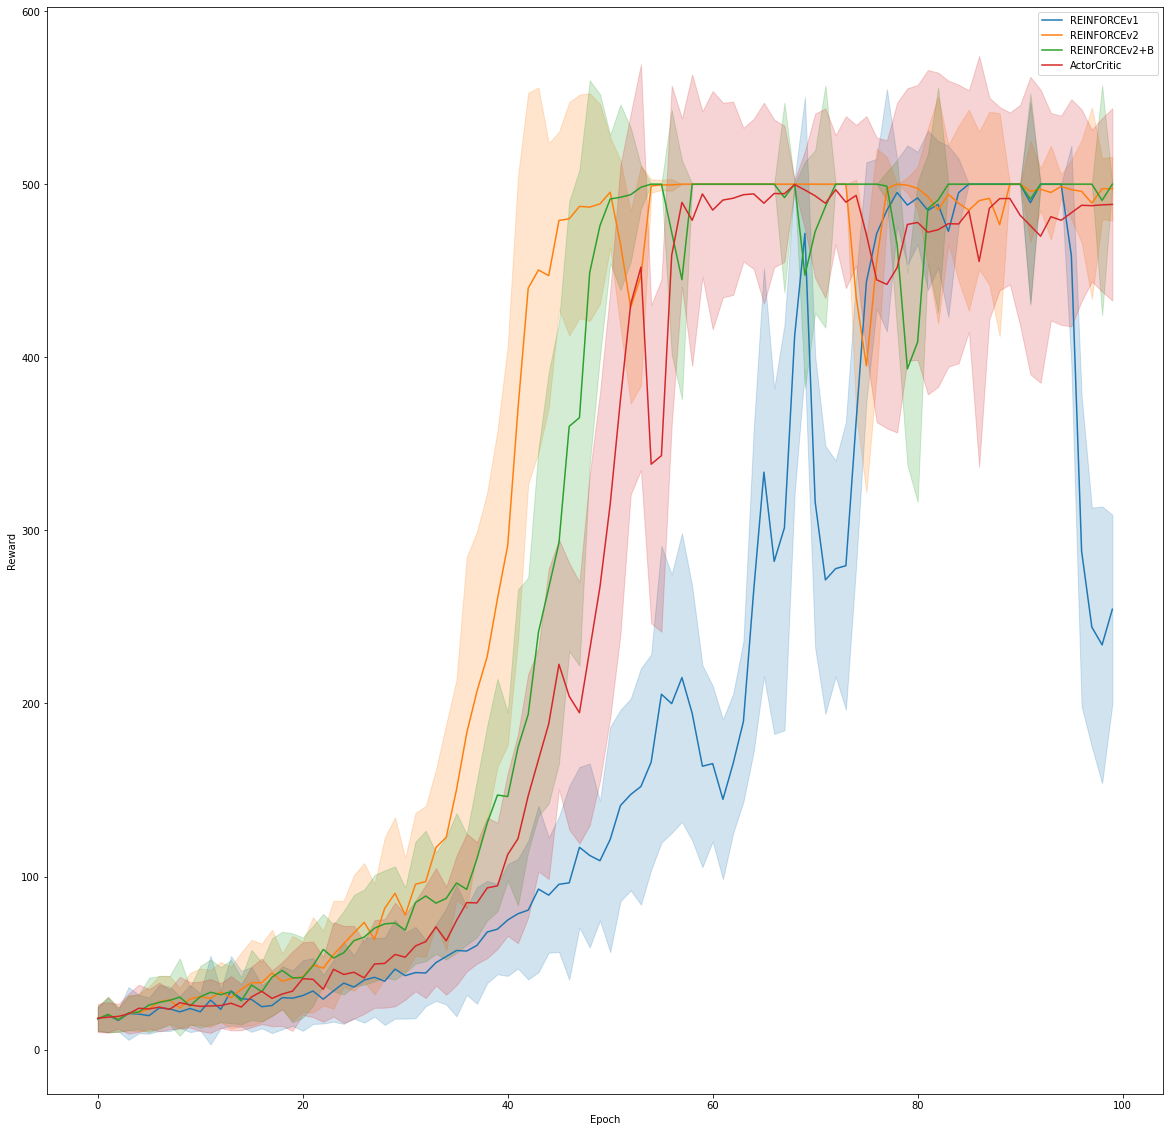

In [32]:
# You will be graded on the output of this cell; So kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv1_rewards, ax)
BaseAgent.plot_rewards(REINFORCEv2_rewards, ax)
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards, ax)
BaseAgent.plot_rewards(ActorCritic_rewards2, ax)
plt.rcParams['figure.figsize'] = [20, 20]
plt.legend(labels=['REINFORCEv1', 'REINFORCEv2', 'REINFORCEv2+B', 'ActorCritic'])